# PCB Defect Detection - Model Visualization

Visualizing YOLOv8 model predictions on random samples from the test dataset.


In [1]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Paths
BASE_DIR = Path(__file__).parent.parent if "__file__" in dir() else Path.cwd().parent
MODEL_PATH = BASE_DIR / "models" / "pcb_defects_yolov8m" / "best.pt"
TEST_IMAGES_DIR = BASE_DIR / "data" / "yolo_dataset" / "images" / "test"

# Class names and colors
CLASS_NAMES = ["missing_hole", "mouse_bite", "open_circuit", "short", "spur", "spurious_copper"]
CLASS_COLORS = {
    "missing_hole": "#FF6B6B",
    "mouse_bite": "#4ECDC4", 
    "open_circuit": "#45B7D1",
    "short": "#96CEB4",
    "spur": "#FFEAA7",
    "spurious_copper": "#DDA0DD"
}

print(f"Model path: {MODEL_PATH}")
print(f"Test images dir: {TEST_IMAGES_DIR}")
print(f"Model exists: {MODEL_PATH.exists()}")


Model path: /Users/bahacelik/Documents/Coding/Automated-Quality-Inspection-Station/models/pcb_defects_yolov8m/best.pt
Test images dir: /Users/bahacelik/Documents/Coding/Automated-Quality-Inspection-Station/data/yolo_dataset/images/test
Model exists: True


In [2]:
# Load the trained model
model = YOLO(MODEL_PATH)
print("✅ Model loaded successfully!")
print(f"Model type: {model.task}")


✅ Model loaded successfully!
Model type: detect


In [3]:
# Get random test images (one from each class for variety)
test_images = list(TEST_IMAGES_DIR.glob("*.jpg"))
print(f"Total test images: {len(test_images)}")

# Select 6 random images (one per class if possible)
selected_images = []
for class_name in CLASS_NAMES:
    class_images = [img for img in test_images if img.name.startswith(class_name.replace("_", " ").title().replace(" ", "_"))]
    if class_images:
        selected_images.append(random.choice(class_images))

# If we don't have 6, add more random ones
while len(selected_images) < 6:
    remaining = [img for img in test_images if img not in selected_images]
    if remaining:
        selected_images.append(random.choice(remaining))
    else:
        break

print(f"\nSelected {len(selected_images)} images for visualization:")
for img in selected_images:
    print(f"  - {img.name}")


Total test images: 70

Selected 6 images for visualization:
  - Short_11_short_08.jpg
  - Spur_11_spur_04.jpg
  - Missing_hole_12_missing_hole_02.jpg
  - Open_circuit_01_open_circuit_04.jpg
  - Missing_hole_08_missing_hole_08.jpg
  - Missing_hole_04_missing_hole_12.jpg


In [4]:
# Run inference on selected images
results = model.predict(
    source=selected_images,
    conf=0.25,  # Confidence threshold
    save=False,
    verbose=False
)

print(f"✅ Inference complete on {len(results)} images")


✅ Inference complete on 6 images


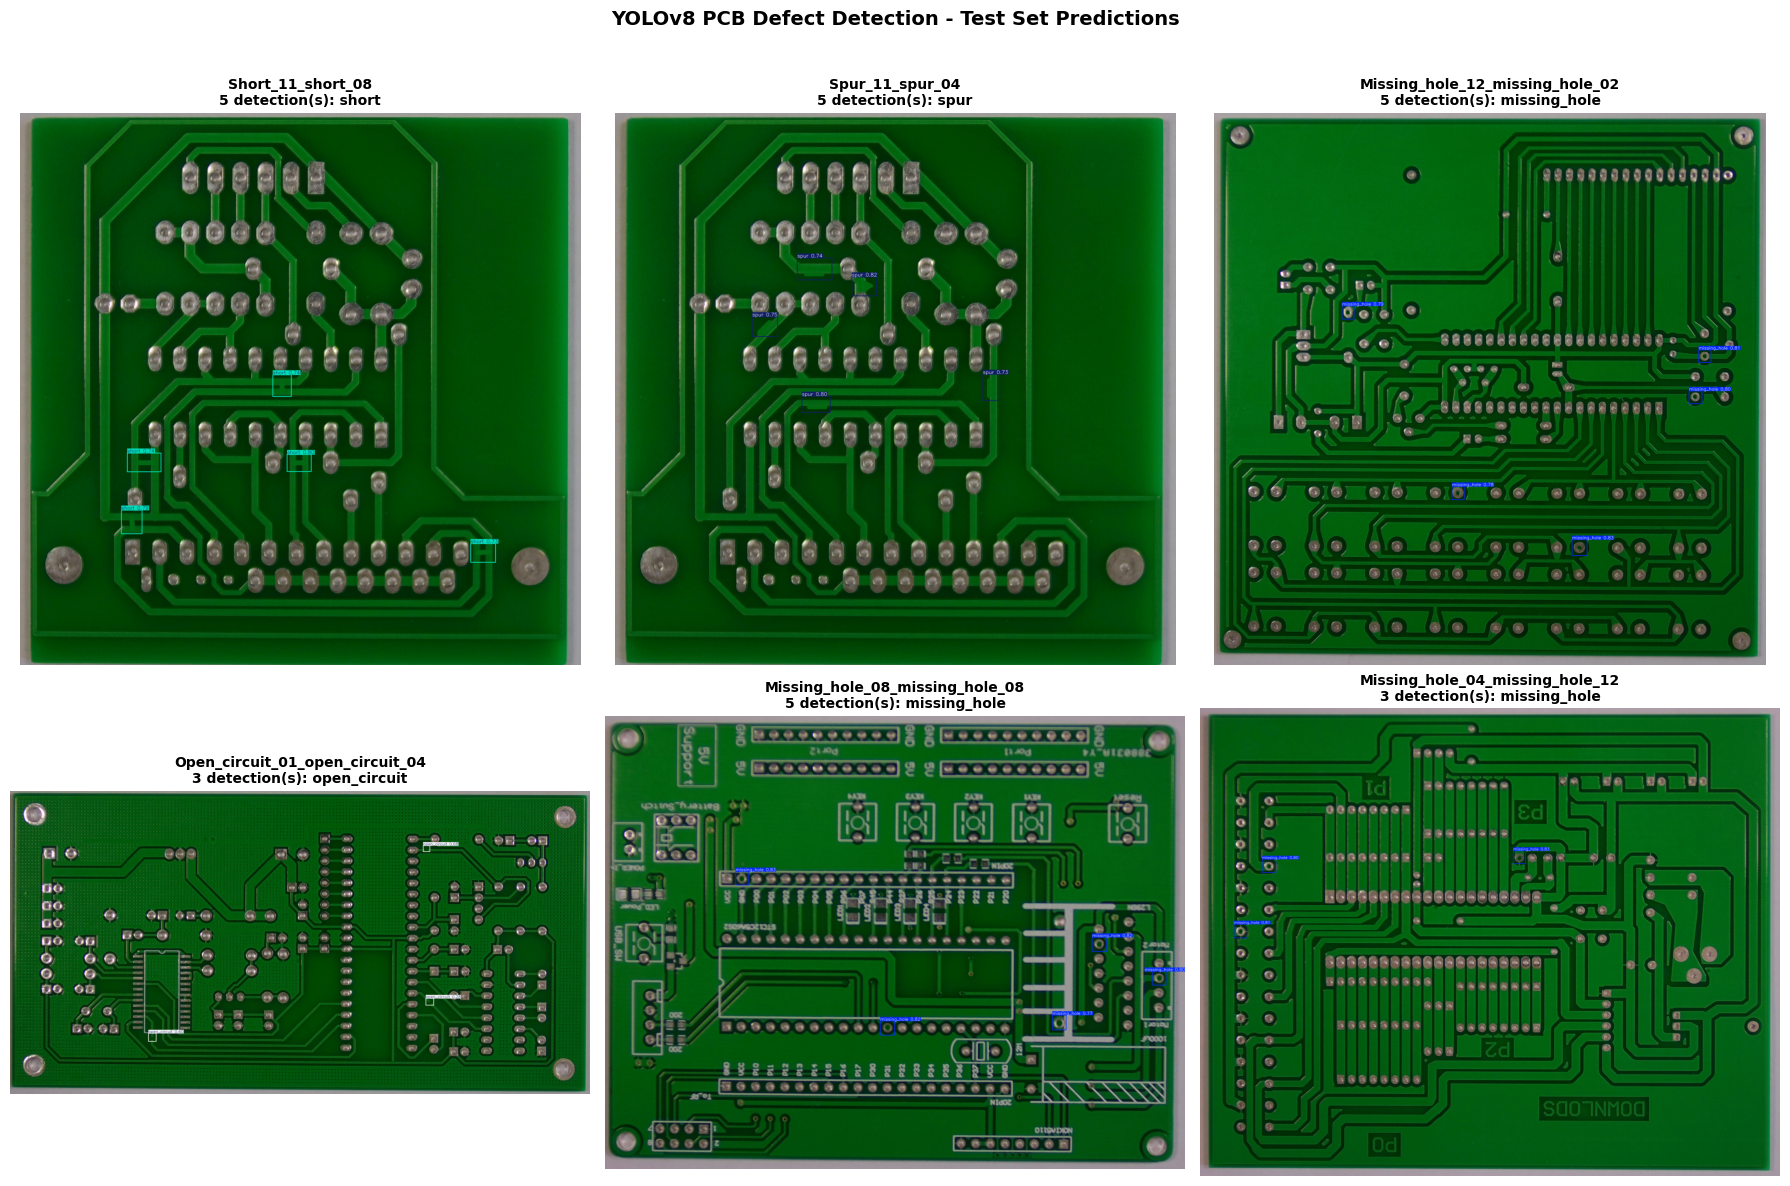

In [5]:
# Visualize results in a grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (result, ax) in enumerate(zip(results, axes)):
    # Get the annotated image with bounding boxes
    annotated_img = result.plot(
        conf=True,
        labels=True,
        line_width=2,
        font_size=10
    )
    
    # Convert BGR to RGB for matplotlib
    annotated_img_rgb = annotated_img[:, :, ::-1]
    
    ax.imshow(annotated_img_rgb)
    ax.axis("off")
    
    # Get detection summary
    boxes = result.boxes
    num_detections = len(boxes)
    
    # Create title with detection info
    img_name = Path(result.path).stem
    if num_detections > 0:
        classes_detected = [CLASS_NAMES[int(cls)] for cls in boxes.cls]
        confs = [f"{conf:.2f}" for conf in boxes.conf]
        title = f"{img_name}\n{num_detections} detection(s): {', '.join(set(classes_detected))}"
    else:
        title = f"{img_name}\nNo detections"
    
    ax.set_title(title, fontsize=10, fontweight="bold")

plt.suptitle("YOLOv8 PCB Defect Detection - Test Set Predictions", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


In [6]:
# Print detailed detection information
print("=" * 70)
print("DETAILED DETECTION RESULTS")
print("=" * 70)

for result in results:
    img_name = Path(result.path).name
    boxes = result.boxes
    
    print(f"\n📷 {img_name}")
    print("-" * 50)
    
    if len(boxes) > 0:
        for i, (box, conf, cls) in enumerate(zip(boxes.xyxy, boxes.conf, boxes.cls)):
            class_name = CLASS_NAMES[int(cls)]
            x1, y1, x2, y2 = box.tolist()
            print(f"  [{i+1}] {class_name:20s} | Conf: {conf:.3f} | Box: ({x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f})")
    else:
        print("  No defects detected")

print("\n" + "=" * 70)


DETAILED DETECTION RESULTS

📷 Short_11_short_08.jpg
--------------------------------------------------
  [1] short                | Conf: 0.802 | Box: (1087, 1392, 1185, 1461)
  [2] short                | Conf: 0.792 | Box: (413, 1619, 496, 1714)
  [3] short                | Conf: 0.744 | Box: (436, 1387, 573, 1462)
  [4] short                | Conf: 0.741 | Box: (1029, 1069, 1104, 1156)
  [5] short                | Conf: 0.726 | Box: (1834, 1755, 1934, 1831)

📷 Spur_11_spur_04.jpg
--------------------------------------------------
  [1] spur                 | Conf: 0.825 | Box: (963, 671, 1063, 748)
  [2] spur                 | Conf: 0.797 | Box: (761, 1155, 875, 1222)
  [3] spur                 | Conf: 0.754 | Box: (559, 832, 662, 913)
  [4] spur                 | Conf: 0.736 | Box: (742, 594, 883, 682)
  [5] spur                 | Conf: 0.727 | Box: (1496, 1066, 1556, 1173)

📷 Missing_hole_12_missing_hole_02.jpg
--------------------------------------------------
  [1] missing_hole  

## Summary Statistics


In [7]:
# Summary statistics
from collections import Counter

all_detections = []
all_confidences = []
images_with_detections = 0

for result in results:
    boxes = result.boxes
    if len(boxes) > 0:
        images_with_detections += 1
        for cls, conf in zip(boxes.cls, boxes.conf):
            all_detections.append(CLASS_NAMES[int(cls)])
            all_confidences.append(float(conf))

class_counts = Counter(all_detections)

print("📊 DETECTION SUMMARY")
print("=" * 50)
print(f"Images processed: {len(results)}")
print(f"Images with detections: {images_with_detections}")
print(f"Total detections: {len(all_detections)}")
print(f"Average confidence: {sum(all_confidences)/len(all_confidences):.3f}" if all_confidences else "N/A")
print()
print("Detections per class:")
for class_name in CLASS_NAMES:
    count = class_counts.get(class_name, 0)
    bar = "█" * count
    print(f"  {class_name:20s}: {count:2d} {bar}")


📊 DETECTION SUMMARY
Images processed: 6
Images with detections: 6
Total detections: 26
Average confidence: 0.757

Detections per class:
  missing_hole        : 13 █████████████
  mouse_bite          :  0 
  open_circuit        :  3 ███
  short               :  5 █████
  spur                :  5 █████
  spurious_copper     :  0 
